# Практика 3 - Температура солнечных модулей

## Расчет температуры модулей

На этой практике ознакомимся с изменением температуры, а также влиянием скорости ветра на температуру ячеек

Используемые понятия:
- температура солнечных элементов и панелей
- данные с NSRDB
- Данные TMY

Используемые понятия Python
- парсинг погодных файлов с [pvlib.iotools.read_tmy3](https://pvlib-python.readthedocs.io/en/stable/generated/pvlib.iotools.read_tmy3.html)
- определение позиции солнца с помощью [pvlib.solarposition.get_solarposition](https://pvlib-python.readthedocs.io/en/stable/generated/pvlib.solarposition.get_solarposition.html)
- расчет температуры модулей с помощью  [Sandia Array Performance Model (SAPM)](https://pvlib-python.readthedocs.io/en/stable/generated/pvlib.temperature.sapm_cell.html)

In [1]:
import pvlib
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
print(pvlib.__version__)

0.9.5


In [7]:
# create a path to the pvlib "data" folder using Python pathlib,
# note how you can use `.__file__` to get the path to the pvlib module,
# the `.parent` attribute to get the directory containing a file,
# and "/" operator add nested folders to the path.  Then read a TMY3 file
# that comes with pvlib python in the "data" folder, coercing the year to 1990
DATA_DIR = pathlib.Path(pvlib.__file__).parent / 'data'
df_tmy, metadata = pvlib.iotools.read_tmy3(DATA_DIR / '723170TYA.CSV', coerce_year=1990)

# pvlib iotools.read_tmy3 returns a Pandas DataFrame of the timeseries
# and dictionary of metadata. Use the coordinates of the TMY3 file to
# create a pvlib python "location"
location = pvlib.location.Location(
    latitude=metadata['latitude'], longitude=metadata['longitude'])

# offset the hourly timeseries by 30-minutes to get the solar positions at the
# center of each interval
times = df_tmy.index - pd.Timedelta('30min')
solar_position = location.get_solarposition(times)
# shift the times to the right side of each interval
solar_position.index += pd.Timedelta('30min')

# calculate the positions at each timestep for a north-south aligned tracker
# note by default backtrack is true and GCR = 1/7
tracker_data = pvlib.tracking.singleaxis(
    solar_position['apparent_zenith'], solar_position['azimuth'], axis_azimuth=180)
# set nighttime tracker positions to stow (zero-degrees is horizontal)
tilt = tracker_data['surface_tilt'].fillna(0)
azimuth = tracker_data['surface_azimuth'].fillna(0)

# get the irradiance components in the plane of the array at each timestep
df_poa_tracker = pvlib.irradiance.get_total_irradiance(
    surface_tilt=tilt,
    surface_azimuth=azimuth,
    dni=df_tmy['DNI'],
    ghi=df_tmy['GHI'],
    dhi=df_tmy['DHI'],
    solar_zenith=solar_position['apparent_zenith'],
    solar_azimuth=solar_position['azimuth'])
tracker_poa = df_poa_tracker['poa_global']

                           poa_global  poa_direct  poa_diffuse  \
1990-01-01 01:00:00-05:00         0.0         0.0          0.0   
1990-01-01 02:00:00-05:00         0.0         0.0          0.0   
1990-01-01 03:00:00-05:00         0.0         0.0          0.0   
1990-01-01 04:00:00-05:00         0.0         0.0          0.0   
1990-01-01 05:00:00-05:00         0.0         0.0          0.0   
...                               ...         ...          ...   
1990-12-31 20:00:00-05:00         0.0         0.0          0.0   
1990-12-31 21:00:00-05:00         0.0         0.0          0.0   
1990-12-31 22:00:00-05:00         0.0         0.0          0.0   
1990-12-31 23:00:00-05:00         0.0         0.0          0.0   
1991-01-01 00:00:00-05:00         0.0         0.0          0.0   

                           poa_sky_diffuse  poa_ground_diffuse  
1990-01-01 01:00:00-05:00              0.0                 0.0  
1990-01-01 02:00:00-05:00              0.0                 0.0  
1990-01-01 0

In [3]:
metadata

{'USAF': 723170,
 'Name': '"GREENSBORO PIEDMONT TRIAD INT"',
 'State': 'NC',
 'TZ': -5.0,
 'latitude': 36.1,
 'longitude': -79.95,
 'altitude': 273.0}

In [4]:
all_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']
list(all_parameters.keys())

['open_rack_glass_glass',
 'close_mount_glass_glass',
 'open_rack_glass_polymer',
 'insulated_back_glass_polymer']

In [5]:
import inspect
source_code=inspect.getsource(pvlib.temperature)
print(source_code)

"""
The ``temperature`` module contains functions for modeling temperature of
PV modules and cells.
"""

import numpy as np
import pandas as pd
from pvlib.tools import sind
from pvlib._deprecation import warn_deprecated
from pvlib.tools import _get_sample_intervals
import scipy
import scipy.constants
import warnings


TEMPERATURE_MODEL_PARAMETERS = {
    'sapm': {
        'open_rack_glass_glass': {'a': -3.47, 'b': -.0594, 'deltaT': 3},
        'close_mount_glass_glass': {'a': -2.98, 'b': -.0471, 'deltaT': 1},
        'open_rack_glass_polymer': {'a': -3.56, 'b': -.0750, 'deltaT': 3},
        'insulated_back_glass_polymer': {'a': -2.81, 'b': -.0455, 'deltaT': 0},
    },
    'pvsyst': {'freestanding': {'u_c': 29.0, 'u_v': 0},
               'insulated': {'u_c': 15.0, 'u_v': 0}}
}
"""Dictionary of temperature parameters organized by model.

There are keys for each model at the top level. Currently there are two models,
``'sapm'`` for the Sandia Array Performance Model, and ``'pvsyst'``. Ea

open_rack_glass_polymer подходит для многих солнечных панелей, поэтому мы будем использовать его здесь:

In [6]:
parameters = all_parameters['open_rack_glass_polymer']
# note the "splat" operator "**" which expands the dictionary "parameters"
# into a comma separated list of keyword arguments
cell_temperature = pvlib.temperature.sapm_cell(
    tracker_poa, df_tmy['DryBulb'], df_tmy['Wspd'], **parameters)

Теперь сравним температуру окружающей среды и температуру ячеек

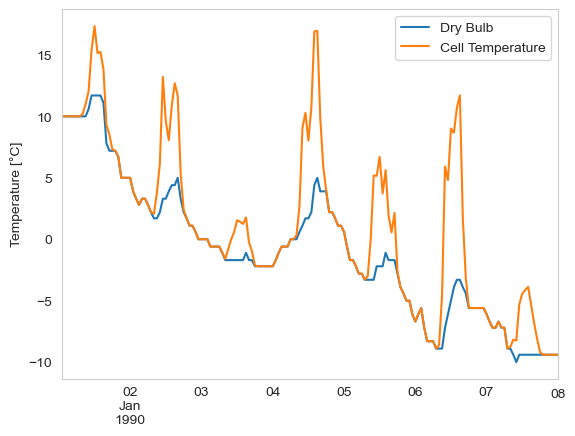

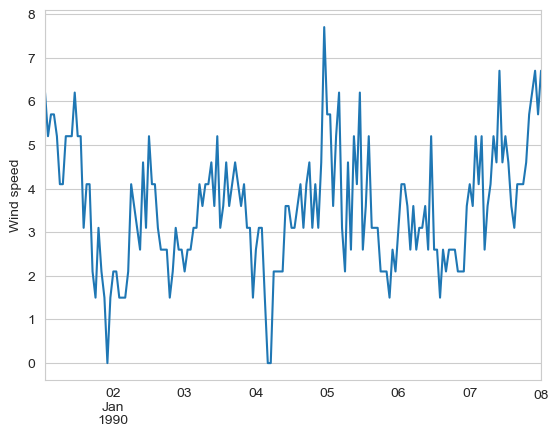

In [7]:
fig, ax1 = plt.subplots()
df_tmy['DryBulb'].head(24*7).plot()
cell_temperature.head(24*7).plot()
plt.grid()
plt.legend(['Dry Bulb', 'Cell Temperature','Wspd'])
# note Python 3 can use unicode characters like the degrees symbol
plt.ylabel('Temperature [°C]');

fig, ax1 = plt.subplots()
df_tmy['Wspd'].head(24*7).plot()
plt.ylabel('Wind speed');

Скорость ветра также оказывает влияние, но ее труднее увидеть на таком графике временного ряда. Чтобы было понятнее, составим точечную диаграмму:

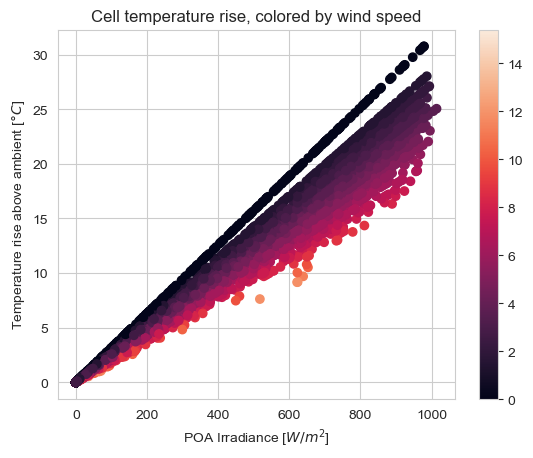

In [7]:
temperature_difference = cell_temperature - df_tmy['DryBulb']
plt.scatter(tracker_poa, temperature_difference, c=df_tmy['Wspd'])
plt.colorbar()
# note you can use LaTeX math in matplotlib labels
# compare \degree" with the unicode symbol above
plt.ylabel('Temperature rise above ambient [$\degree C$]')
plt.xlabel('POA Irradiance [$W/m^2$]');
plt.title('Cell temperature rise, colored by wind speed');

In [8]:
temperature_difference_no_zero = temperature_difference[temperature_difference != 0]

In [9]:
corr_matrix_for = pd.merge(temperature_difference_no_zero.rename('Temp_diff'), df_tmy[['Wspd', 'GHI']], left_index=True, right_index=True)

In [10]:
corr_matrix_for

,Temp_diff,Wspd,GHI
1990-01-01 08:00:00-05:00,0.200292,5.2,9
1990-01-01 09:00:00-05:00,0.998087,5.2,46
1990-01-01 10:00:00-05:00,1.437120,5.2,79
1990-01-01 11:00:00-05:00,3.700839,6.2,199
1990-01-01 12:00:00-05:00,5.645697,5.2,261
...,...,...,...
1990-12-31 14:00:00-05:00,5.802984,2.6,230
1990-12-31 15:00:00-05:00,4.306439,2.6,188
1990-12-31 16:00:00-05:00,2.591865,3.1,131
1990-12-31 17:00:00-05:00,1.266351,2.6,49


In [11]:
corr_matrix = corr_matrix_for.corr()
print(corr_matrix)

           Temp_diff      Wspd       GHI
Temp_diff   1.000000 -0.055764  0.918393
Wspd       -0.055764  1.000000  0.108746
GHI         0.918393  0.108746  1.000000


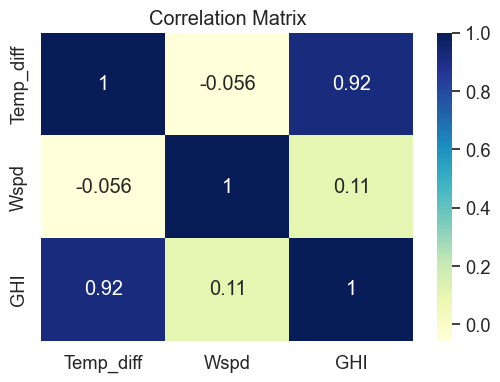

In [12]:
import seaborn as sns
sns.set(font_scale=1.2)
plt.figure(figsize=(6,4))
sns.heatmap(corr_matrix, annot=True, cmap="YlGnBu")
plt.title('Correlation Matrix')
plt.show()

Основной тенденцией является большая разница температур по мере увеличения падающего излучения.
Однако этот график показывает, что более высокая скорость ветра снижает эффект — более быстрый ветер означает большее конвективное охлаждение, поэтому температура ячейки ниже, чем в спокойном воздухе.
Примечание: разрыв на верхней границе тренда является артефактом низкого разрешения значений скорости ветра в этом наборе данных TMY; нет значений между 0 и 0,3 м/с.

## Задание

В папке данных pvlib есть еще один, более старый файл TMY3: «703165TY.csv».
1) Создайте путь к файлу TMY3: «703165TY.csv», используя DATA_DIR и оператор /
2) Прочитать временные ряды и метаданные из файла
3) Как называется станция в метаданных?
4) Предполагая, что солнечная панель находится на горизонтально плоской крыше, используйте SAPM для расчета температуры солнечных модулей.
5) Определите значение POA и сравните его с GHI в разное время года.
6) Какой наклон следует использовать для крышной панели?
7) Сравните данные о температуре окружающей среды за первую неделю с расчетной температурой солнечной панели.